# How to Renovate Your Room

- https://medium.com/@melgor89/generative-interior-design-challenge-2024-2nd-place-solution-6338f19f6fe3

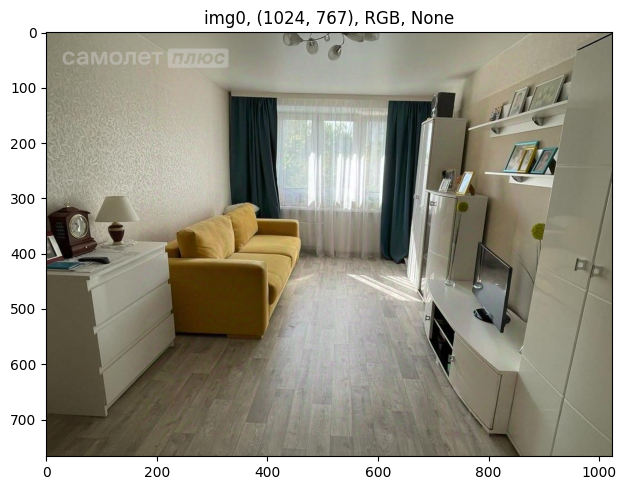

In [2]:
import cv2
import torch
import numpy as np
from PIL import Image
from utils import display_images


DEVICE = 'cuda:0'
CACHE_DIR = '/home/a.lugovoi/Git/rnd-tasks/generative-ai-research/cache'
img_pil = Image.open('data/img5001_BDorig.png').convert('RGB')
display_images([img_pil])

# Step 1: simple img2img

## img2img stable-diffusion-v15
- https://huggingface.co/docs/diffusers/en/using-diffusers/img2img#stable-diffusion-v15

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

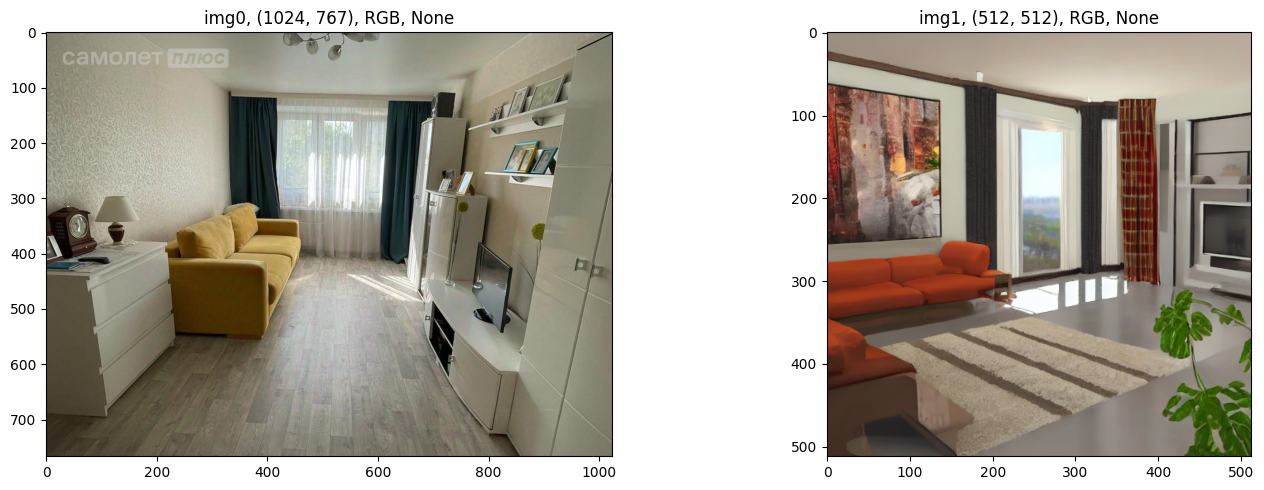

CPU times: user 7.81 s, sys: 697 ms, total: 8.51 s
Wall time: 7.45 s


In [29]:
%%time

from diffusers import AutoPipelineForImage2Image

pipe = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    cache_dir=CACHE_DIR
).to(DEVICE)

prompt = "New modern style of livingroom, warm color palette, detailed, 8k"
img_gen = pipe(prompt, image=img_pil.resize((512, 512)), strenght=0.7, num_inference_steps=100)
display_images([img_pil] + img_gen.images)

## img2img stable-diffusion-xl-sdxl
- https://huggingface.co/docs/diffusers/en/using-diffusers/img2img#stable-diffusion-xl-sdxl

/home/a.lugovoi/.conda/envs/a.lugovoi.py310/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
2024-04-24 18:59:26.020459: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 18:59:26.023576: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 18:59:26.082846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations,

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

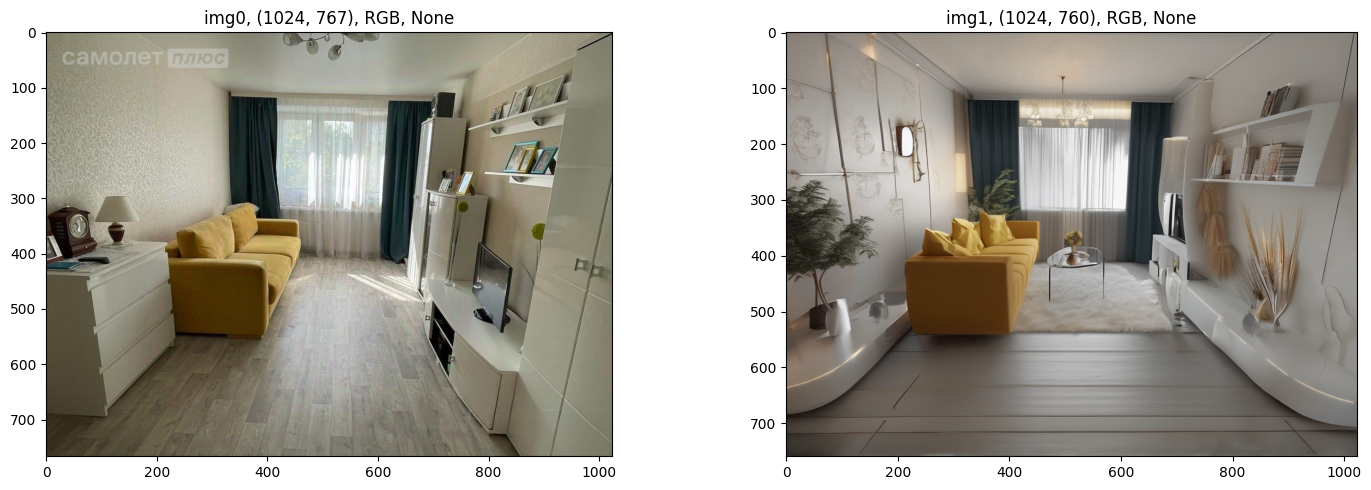

CPU times: user 19 s, sys: 6.94 s, total: 26 s
Wall time: 19.9 s


In [2]:
%%time

from diffusers import AutoPipelineForImage2Image

pipe = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    cache_dir=CACHE_DIR
).to(DEVICE)

prompt = "New modern style of livingroom, warm color palette, detailed, 8k"

img_gen = pipe(prompt, image=img_pil, strength=0.7, num_inference_steps=100)
display_images([img_pil] + img_gen.images)

# Step 2: ControlNet txt2img

## diffusers/controlnet-canny-sdxl-1.0

- https://huggingface.co/docs/diffusers/en/api/pipelines/controlnet_sdxl#diffusers.StableDiffusionXLControlNetPipeline.__call__.example

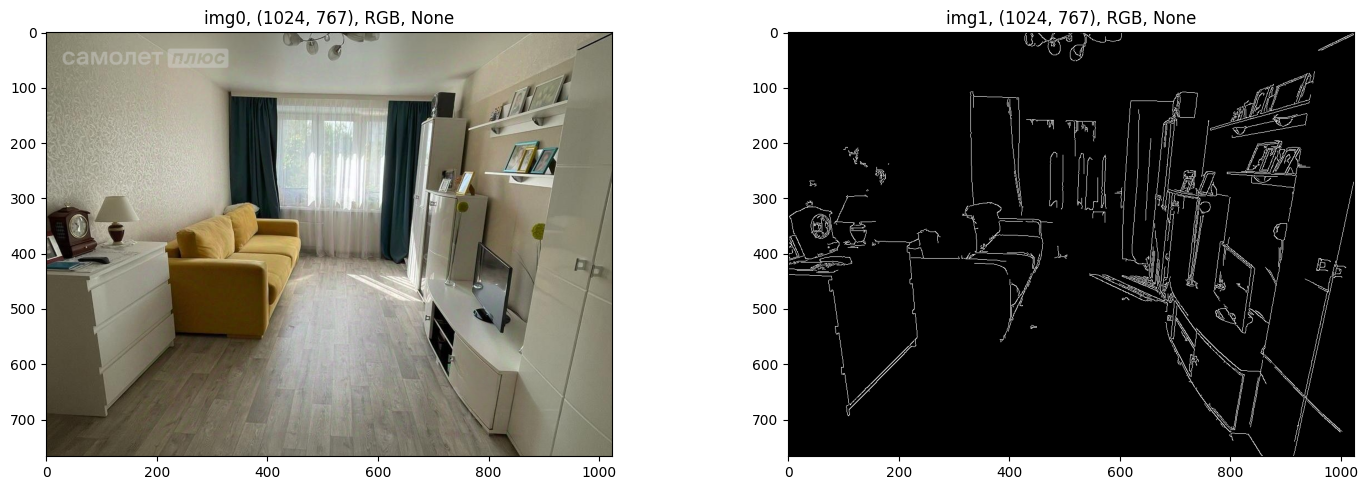

In [11]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

img_canny = np.array(img_pil).copy()
img_canny = cv2.Canny(img_canny, 100, 300)
img_canny = img_canny[:, :, None]
img_canny = np.concatenate([img_canny, img_canny, img_canny], axis=2)
img_canny = Image.fromarray(img_canny)
display_images([img_pil, img_canny])

In [12]:
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)
# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir=CACHE_DIR)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    # vae=vae,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)
# pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

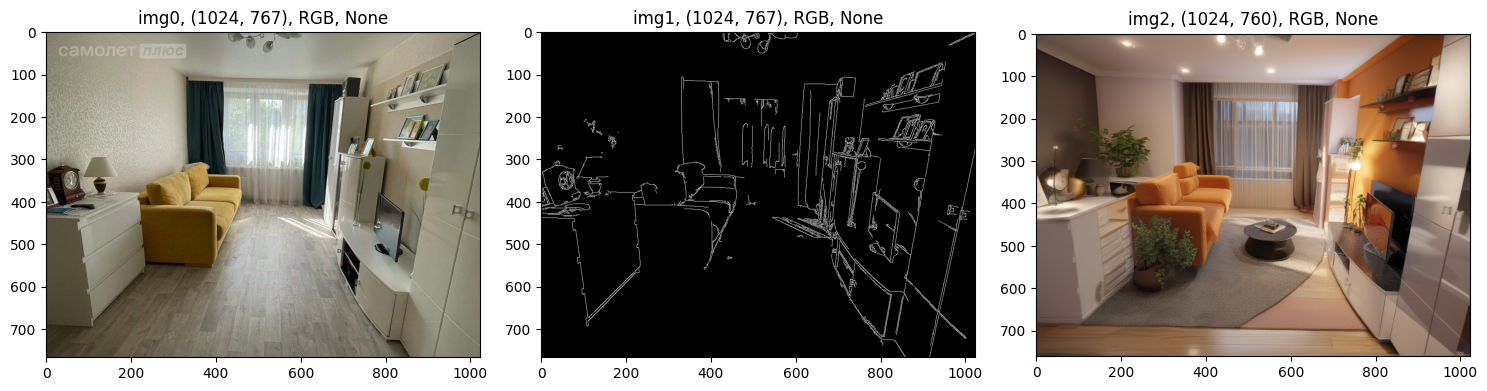

CPU times: user 26.4 s, sys: 3.94 s, total: 30.3 s
Wall time: 29.3 s


In [15]:
%%time

prompt = ["New modern style of livingroom, warm color palette, detailed, 8k"]
negative_prompt = ["low quality, bad quality, sketches"]

img_gen = pipe(
    prompt, 
    negative_prompt=negative_prompt, 
    image=img_canny, 
    controlnet_conditioning_scale=0.6,
    guidance_scale=9,
    eta=0.0,
    generator=torch.Generator(DEVICE).manual_seed(2),
    num_inference_steps=100
)

display_images([img_pil, img_canny] + img_gen.images)

## diffusers/controlnet-depth-sdxl-1.0

- https://huggingface.co/diffusers/controlnet-depth-sdxl-1.0

- for the depth map we will use dpt-beit-large-512 model instead dpt-hybrid-midas (as in the example with diffusers)
- the benchmark of the depth models: https://github.com/isl-org/MiDaS/tree/master

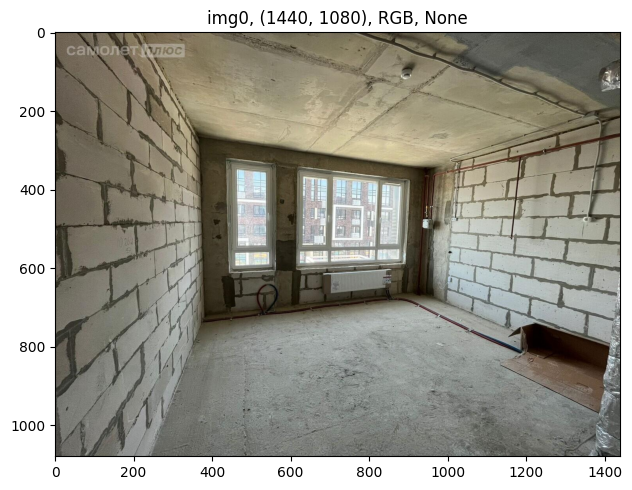

In [4]:
img_pil = Image.open('data/img5003_PrimaryHouse.jpg').convert('RGB')
display_images([img_pil])

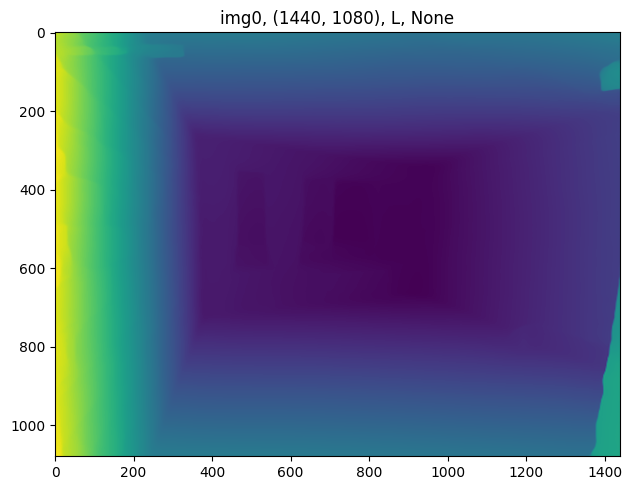

CPU times: user 1min 30s, sys: 29.1 s, total: 1min 59s
Wall time: 3.43 s


In [15]:
%%time

from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL


processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)#.to(DEVICE)

# prepare image for the model
inputs = processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img_pil.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
img_depth = Image.fromarray(formatted)
display_images([img_depth])

In [16]:
%%time

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)

# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to(DEVICE)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    # vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)
# pipe.enable_model_cpu_offload()

# pipe.load_lora_weights('/home/a.lugovoi/Git/rnd-tasks/generative-ai/models/tuned/MODEL_STYLE1/5000/pytorch_lora_weights.safetensors')
# pipe = pipe.to(DEVICE)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 2.35 s, sys: 926 ms, total: 3.28 s
Wall time: 3.8 s


  0%|          | 0/100 [00:00<?, ?it/s]

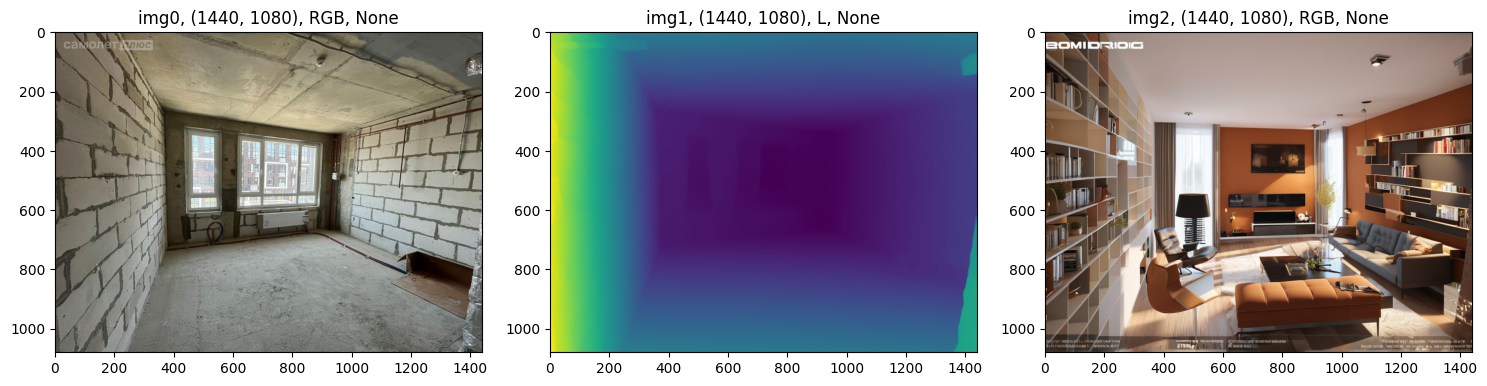

CPU times: user 38.9 s, sys: 11.8 s, total: 50.8 s
Wall time: 49.7 s


In [17]:
%%time

prompt = ["New modern style of livingroom, warm color palette, detailed, 8k"]
negative_prompt = ["low quality, bad quality, sketches"]

img_gen = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=img_depth,
    guidance_scale=13,
    num_images_per_prompt=1,
    num_inference_steps=100, 
    controlnet_conditioning_scale=0.5,
    generator = torch.Generator(DEVICE).manual_seed(8)
)

display_images([img_pil, img_depth] + img_gen.images)

## StableDiffusionXLControlNetImg2ImgPipeline

- https://huggingface.co/docs/diffusers/api/pipelines/controlnet_sdxl#diffusers.StableDiffusionXLControlNetImg2ImgPipeline

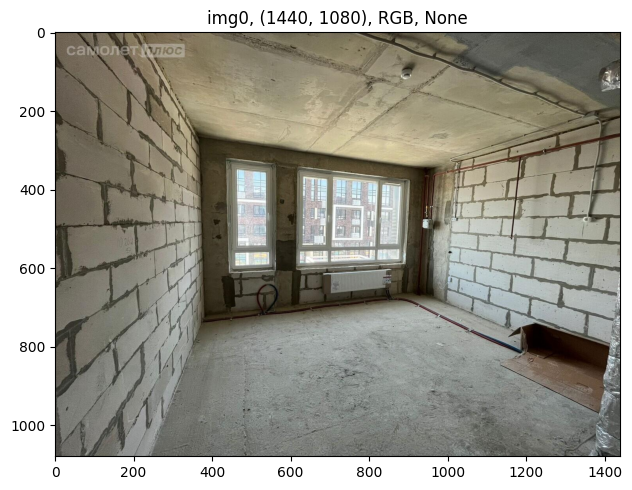

In [3]:
img_pil = Image.open('data/img5003_PrimaryHouse.jpg').convert('RGB')
display_images([img_pil])

2024-05-20 09:09:05.495520: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 09:09:05.498666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 09:09:05.559099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 09:09:06.523882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


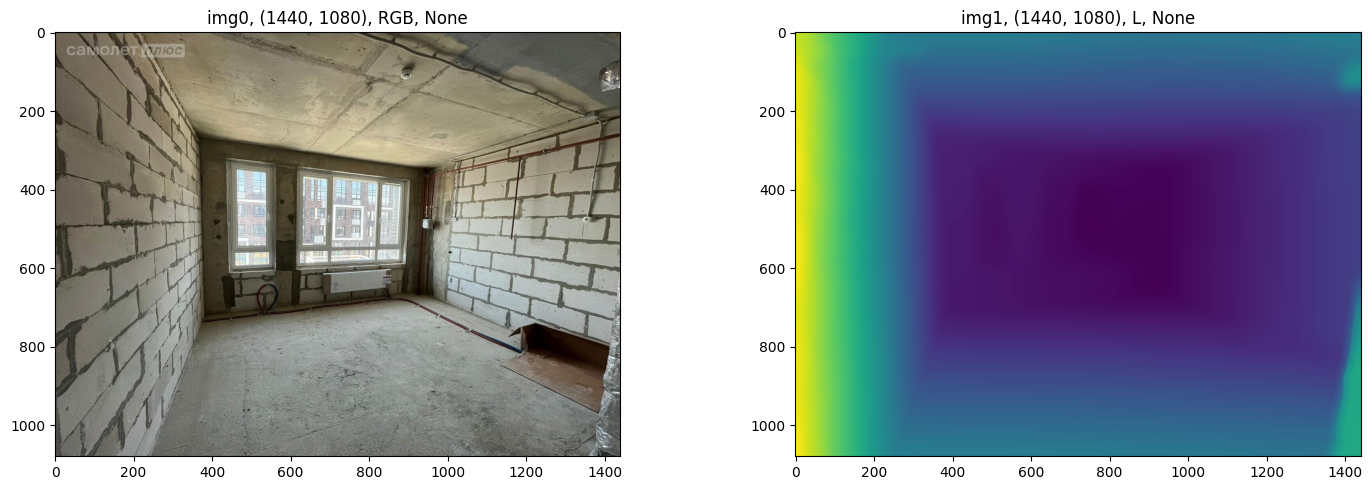

CPU times: user 1min 57s, sys: 33 s, total: 2min 30s
Wall time: 9.3 s


In [4]:
%%time

from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline


processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)#.to(DEVICE)

# prepare image for the model
inputs = processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img_pil.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")

formatted = cv2.bilateralFilter(formatted, 50, 90, 90)

img_depth = Image.fromarray(formatted)
display_images([img_pil, img_depth])

In [5]:
%%time

controlnet = ControlNetModel.from_pretrained(
    'diffusers/controlnet-depth-sdxl-1.0-small',
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)

pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 2.23 s, sys: 851 ms, total: 3.08 s
Wall time: 3.67 s


In [11]:
import yaml
from pprint import pprint 
with open('/home/a.lugovoi/Git/rnd-tasks/generative-ai/notebooks/style/style_prompts.yml', 'r', encoding='utf-8') as file:
    STYLE_PROMPTS = yaml.safe_load(file)

In [13]:
style = 'STYLE_1'
room = 'livingroom'

PROMPT = 'livingroom, ' + STYLE_PROMPTS[style]['prompt'] + STYLE_PROMPTS['QUALITY']['prompt']
NEGATIVE_PROMPT = STYLE_PROMPTS[style]['negative_prompt'] + STYLE_PROMPTS['QUALITY']['negative_prompt']

print(len(PROMPT.split()))
pprint(PROMPT)
print(len(NEGATIVE_PROMPT.split()))
pprint(NEGATIVE_PROMPT)

39
('livingroom, Modern Interior Style, Clear lines and shapes, Mixed lighting, '
 'Functionality with high-quality finish, Minimalism using modern materials, '
 'Neutral color palette with matte surfaces, Open spaces with technological '
 'featuresdenoise, true-to-life textures, photorealistic, hyperrealistic, '
 'highly detailed, high definition, 8k resolution')
34
('Enclosed, isolated spaces, Classic furniture with heavy textiles and '
 'excessive decoration, Decorative wall patterns, moldings, cornices, '
 'Traditional materials, Bright, contrasting colors and patternslow quality, '
 'sketch, cartoon, deformed, distortions, messy, exaggerated proportions, '
 'blurry, unfocused, surreal')


  0%|          | 0/135 [00:00<?, ?it/s]

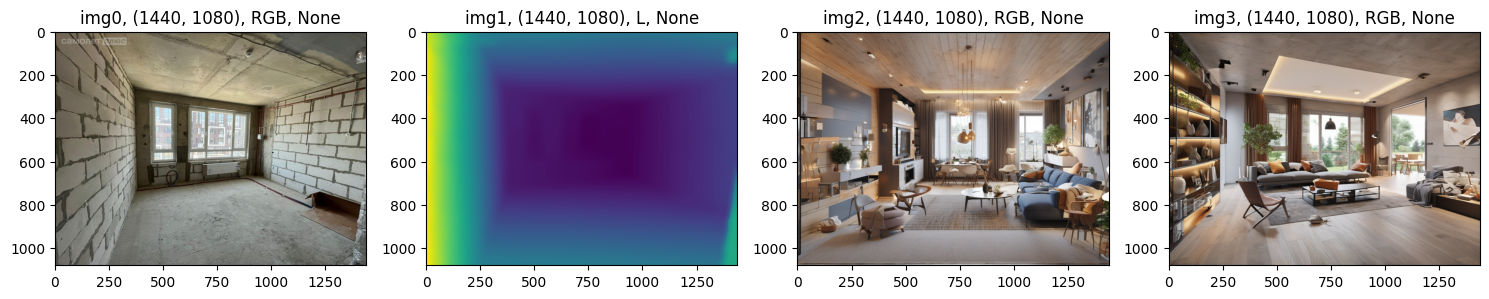

CPU times: user 1min 16s, sys: 21.1 s, total: 1min 37s
Wall time: 1min 35s


In [19]:
%%time

prompt = ["New modern style of livingroom, warm color palette, detailed, 8k"]
negative_prompt = ["low quality, bad quality, sketches"]

img_gen = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=img_pil,
    control_image=img_depth,
    strength=0.9,
    eta=0.0,
    num_inference_steps=150,
    controlnet_conditioning_scale=0.4,
    guidance_scale=12,
    num_images_per_prompt=2,
    generator = torch.Generator(DEVICE).manual_seed(23)
)

display_images([img_pil, img_depth] + img_gen.images)

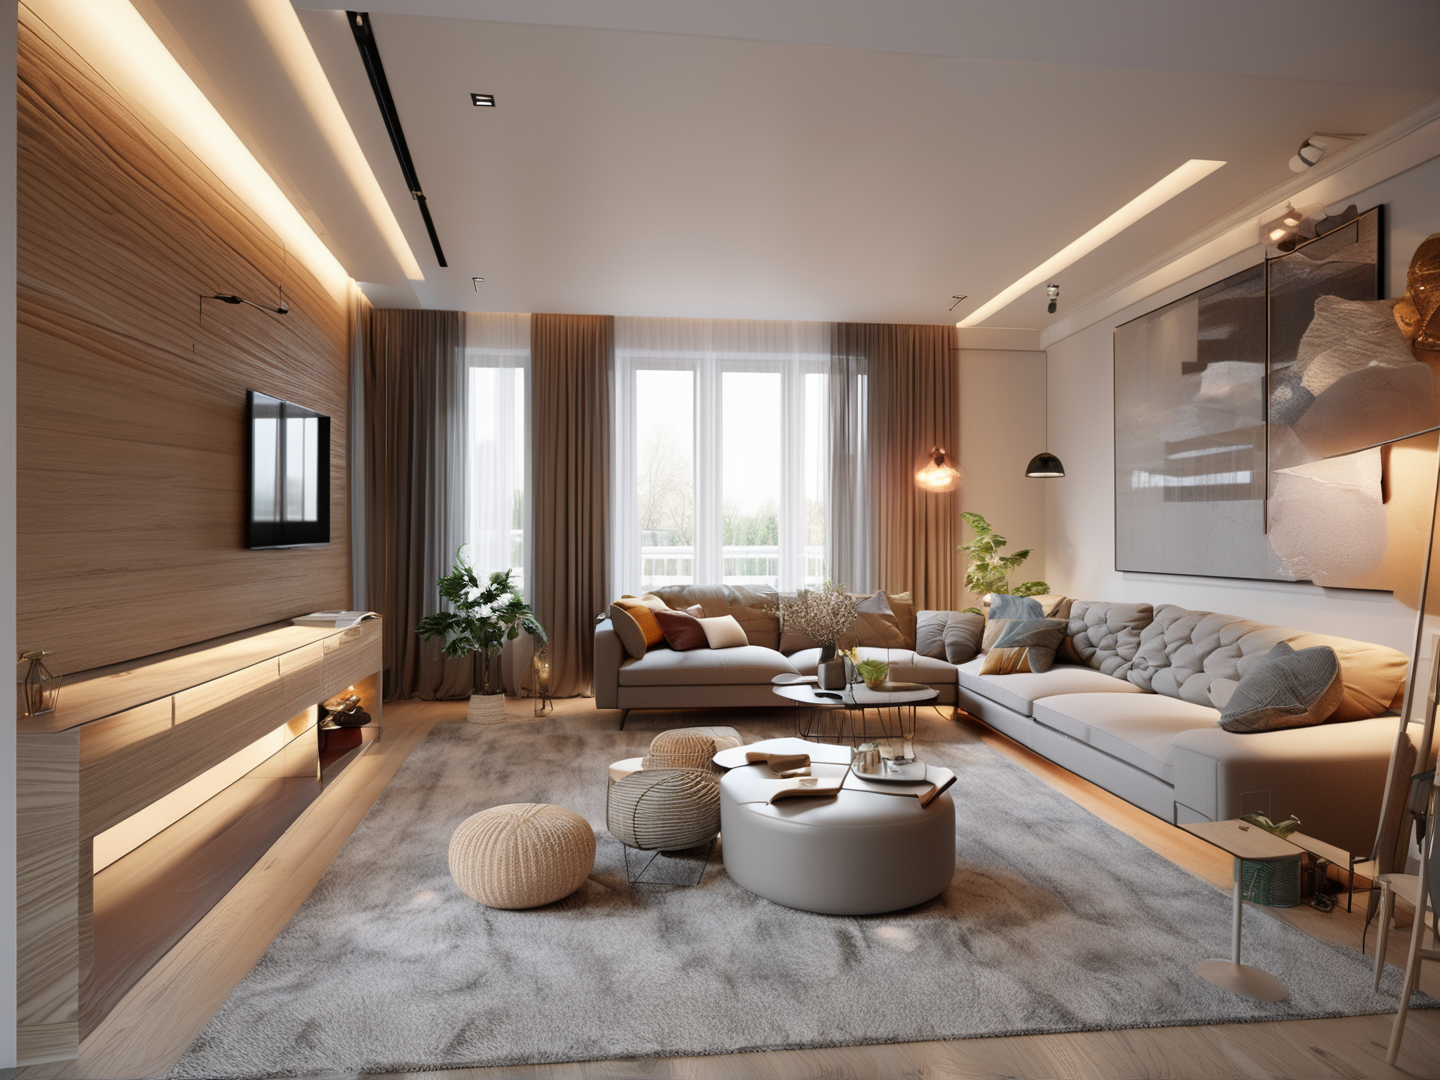

In [15]:
img_gen.images[0]

# END